In [1]:
import h5py
import numpy as np
from obspy.core import UTCDateTime

# MORE FILES (like the plots) CAN BE FOUND ON LAPTOP @ /gnss-picker/data/realdata/summer23/

realdata_dir = '/home/sdybing/gnss-picker/data/realdata/summer23/'

real_data = h5py.File(realdata_dir + 'demean_realdata.hdf5', 'r')
real_data = real_data['demean_realdata'][:,:]
real_metadata = np.load(realdata_dir + 'realdata_info.npy')
# Need to associate each row in this with a 1 or a 0 if
# an earthquake is supposed to be found there

# real_metadata columns:
# 0: station name
# 1: date sample came from
# 2: sample start time
# 3: sample end time
# 4: random n counter

event_catalog = np.genfromtxt(realdata_dir + 'minM4.3_event_catalog.txt', dtype = 'U')
# print(event_catalog)

arrivaltimes = np.load(realdata_dir + 'minM4.3_gnss_arrival_times.npy')

# arrivaltimes columns:
# 0: event ID
# 1: magnitude
# 2: station name
# 3: arrival time in sample

In [2]:
k = np.where(real_metadata[:,0] == 'CCCC')[0]

In [3]:
# test_metadata = real_metadata[26650:28400,:] # BEPK 7/04 17 hrs to 7/07 6 hrs
test_metadata = real_metadata[k[0] + 473:k[-1] - 3216,:]

In [4]:
test_metadata

array([['CCCC', '20190704', '2019-07-04T16:41:11.000000Z',
        '2019-07-04T16:43:18.000000Z', '473'],
       ['CCCC', '20190704', '2019-07-04T16:43:18.000000Z',
        '2019-07-04T16:45:25.000000Z', '474'],
       ['CCCC', '20190704', '2019-07-04T16:45:25.000000Z',
        '2019-07-04T16:47:32.000000Z', '475'],
       ...,
       ['CCCC', '20190707', '2019-07-07T06:21:00.000000Z',
        '2019-07-07T06:23:07.000000Z', '180'],
       ['CCCC', '20190707', '2019-07-07T06:23:07.000000Z',
        '2019-07-07T06:25:14.000000Z', '181'],
       ['CCCC', '20190707', '2019-07-07T06:25:14.000000Z',
        '2019-07-07T06:27:21.000000Z', '182']], dtype='<U27')

In [5]:
print(real_data.shape)
print(real_metadata[0])
print(real_metadata.shape)
print(test_metadata.shape)
print(arrivaltimes[6403])
print(arrivaltimes.shape)

(1061760, 384)
['ACSB' '20190704' '2019-07-04T00:00:00.000000Z'
 '2019-07-04T00:02:07.000000Z' '0']
(1061760, 5)
(1750, 5)
['39281127' '4.50' 'BEPK' '2020-07-06T06:13:37.686480Z']
(100636, 4)


In [29]:
rows_with_eqs = []
rows_without_eqs = []
p_count_info = []
mags = []
gauss_positions = []

counter = 0

for krow in range(len(real_metadata)):
# for krow in range(len(test_metadata)):
    
#     print('-----------------------------')
    
    sta = real_metadata[krow,0]
    date = real_metadata[krow,1]
    starttime = UTCDateTime(real_metadata[krow,2])
    endtime = UTCDateTime(real_metadata[krow,3])
    
#     sta = test_metadata[krow,0]
#     date = test_metadata[krow,1]
#     starttime = UTCDateTime(test_metadata[krow,2])
#     endtime = UTCDateTime(test_metadata[krow,3])
    
#     print('-----------------------------')
#     print('Metadata row info:')
#     print('Station: ' + str(sta))
#     print('Sample date: ' + str(date))
#     print('Sample start time: ' + str(starttime))
#     print('Sample end time: ' + str(endtime))
    
    arrival_stas = arrivaltimes[:,2]
    
#     print(arrival_stas)
        
    matches = np.where(arrival_stas == sta)[0] # Find the rows in the arrival times array for this station
#     print(matches)
    
    p_pick_count = 0
    
    for i in matches:
        
        mag = arrivaltimes[i,1]
        arrival_sta = arrivaltimes[i,2]
        p_arrival = arrivaltimes[i,3]
        
#         print('-----------------------------')
#         print('Arrival times row info:')
#         print('Magnitude: ' + str(mag))
#         print('Station: ' + str(arrival_sta))
#         print('Arrival time: ' + str(p_arrival))
        
        if p_pick_count == 0: # If we haven't found any P waves yet in the metadata row:
        
            if p_arrival != 'nan': # If the P wave arrival time in the arrivaltimes array is not 'nan' (aka it exists):
                
#                 print('-----------------------------')
#                 print('Good P-wave')
                
                p_arrival = UTCDateTime(p_arrival) # Convert the P arrival time from the array to a UTCDateTime object
#                 print('P-arrival: ' + str(p_arrival))
#                 print('Metadata row start time: ' + str(starttime))
#                 print('Metadata row end time: ' + str(endtime))
                
                p_start_delta = p_arrival - starttime # If the P arrival minus the metadata row start time is greater than or equal to 0 but less than 128, the p_arrival is in the sample
                # print(p_start_delta)
                
                if p_start_delta >= 0 and p_start_delta < 128: # If the delta is 0, the Gaussian should be positioned at the first sample (index 0).
                    
                    gauss_position = round(p_start_delta) # Rounded to the nearest whole index
                    p_pick_count += 1 # Since we found an arrival in this metadata row, add one to the pick count
                    
                    if float(mag) > 6:
                        print('P-wave in this sample (metadata row ' + str(krow) + ') at index ' + str(gauss_position) + ', station ' + str(arrival_sta) + '/' + str(sta) + ', magnitude + ' + str(mag))
                    
                    gauss_positions.append(gauss_position) # Add the index of the sample that should have the gaussian peak to the list of gaussian positions.
                    mags.append(mag)
                    
                    # print(krow)
                    # print(mag)
                    # print(index) # this is the index in arrival_times where the eq is
                
                else: # If the delta is greater than 128, the arrival time is not in the metadata array. Skip it.
                    
                    pass
            
            elif p_arrival == 'nan': # If there isn't a calculated arrival time for this row in the arrivaltimes array, skip it.
                
                gauss_position = 'nan' # If there is no p arrival in the sample, the gaussian will not exist so the position is 'nan'.
                mag = 'nan'
                pass
        
        elif p_pick_count > 0: # If the count is already greater than 1 because we've found a p wave in this row of the metadata array, we'll skip any extras for making gaussian positions (but still add them to the count so we know they exist).
            
            if p_arrival != 'nan': 
                p_arrival = UTCDateTime(p_arrival) 
                p_start_delta = p_arrival - starttime 

                if p_start_delta >= 0 and p_start_delta < 128:  
                    p_pick_count += 1
                
                else:
                    pass

            elif p_arrival == 'nan': 
                pass
    
    if p_pick_count == 0:
        
        rows_without_eqs.append(krow) # Add the index of the row in the metadata array that doesn't have an earthquake to the list of indices that don't have earthquakes.
        p_count_info.append(p_pick_count) # Add the number of p picks in the metadata array row (zero) to the p_count list.
        gauss_positions.append(gauss_position) # Add the gauss position (in this case 'nan' because there are no picks in this row of the metadata array) to the list of positions.
        mags.append(mag)
        
        # These might be VERY WRONG - need to be inside the index loop to not just have only the last value!
        
    elif p_pick_count != 0:
        
        rows_with_eqs.append(krow) # Add the index of the row in the metadata array that does have an earthquake to the list of indices that do have earthquakes.
        p_count_info.append(p_pick_count) # Add the number of p picks in the metadata array row to the p_count list.
        
    counter += 1
    # print(counter)


P-wave in this sample (metadata row 16138) at index 10, station BBRY/BBRY, magnitude + 6.40
P-wave in this sample (metadata row 26674) at index 120, station BEPK/BEPK, magnitude + 6.40
P-wave in this sample (metadata row 27631) at index 64, station BEPK/BEPK, magnitude + 7.10
P-wave in this sample (metadata row 37555) at index 5, station BKAP/BKAP, magnitude + 6.40
P-wave in this sample (metadata row 40955) at index 15, station BKMS/BKMS, magnitude + 6.40
P-wave in this sample (metadata row 46164) at index 14, station BMHL/BMHL, magnitude + 6.40
P-wave in this sample (metadata row 51581) at index 96, station BSRY/BSRY, magnitude + 6.40
P-wave in this sample (metadata row 55564) at index 72, station BVPP/BVPP, magnitude + 6.40
P-wave in this sample (metadata row 90408) at index 115, station CCCC/CCCC, magnitude + 6.40
P-wave in this sample (metadata row 91365) at index 60, station CCCC/CCCC, magnitude + 7.10
P-wave in this sample (metadata row 95849) at index 6, station CDMT/CDMT, magni

P-wave in this sample (metadata row 780340) at index 119, station P616/P616, magnitude + 6.40
P-wave in this sample (metadata row 781297) at index 63, station P616/P616, magnitude + 7.10
P-wave in this sample (metadata row 798046) at index 13, station P622/P622, magnitude + 6.40
P-wave in this sample (metadata row 904469) at index 14, station P800/P800, magnitude + 6.40
P-wave in this sample (metadata row 909229) at index 8, station P810/P810, magnitude + 6.40
P-wave in this sample (metadata row 914668) at index 123, station P811/P811, magnitude + 6.40
P-wave in this sample (metadata row 915625) at index 68, station P811/P811, magnitude + 7.10
P-wave in this sample (metadata row 920385) at index 68, station P812/P812, magnitude + 7.10
P-wave in this sample (metadata row 924867) at index 40, station PBPP/PBPP, magnitude + 6.40
P-wave in this sample (metadata row 925823) at index 79, station PBPP/PBPP, magnitude + 7.10
P-wave in this sample (metadata row 952720) at index 118, station RAM

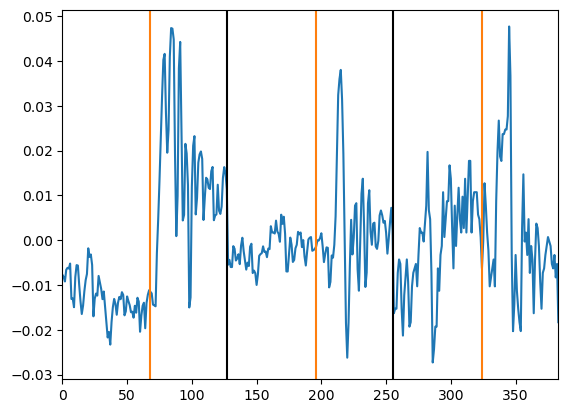

In [11]:
# Testing plots

import matplotlib.pyplot as plt

mdrow = 110405
index = 68

# mdrow = 692198
# index = 70

plt.plot(real_data[mdrow])
plt.axvline(127, color = 'black') # last sample of N. E starts at 256
plt.axvline(255, color = 'black') # last sample of E. Z starts at 512
plt.axvline(index, color = 'C1')
plt.axvline(128 + index, color = 'C1')
plt.axvline(256 + index, color = 'C1')
plt.xlim(0,383);

In [30]:
# Checks to make sure things add up correctly

# print(rows_with_eqs)
# print(rows_without_eqs)
# print(p_count_info)
# print(mags)
# print(gauss_positions)

print(len(real_metadata))
print(len(rows_without_eqs) + len(rows_with_eqs))
print(len(p_count_info))
print(len(mags))
print(len(gauss_positions)) # All four of these should match

print(len(rows_with_eqs))
a = np.where(np.array(gauss_positions) != 'nan')[0]
print(len(a)) # This should match len(rows_with_eqs)

1061760
1061760
1061760
1061760
1061760
2313
2313


In [31]:
### Adding gauss position column to metadata array

gauss_pos_vector = np.array(gauss_positions).reshape(len(gauss_positions),1)
mag_vector = np.array(mags).reshape(len(mags),1)

a = np.append(real_metadata, gauss_pos_vector, axis = 1)
new_meta_array = np.append(a, mag_vector, axis = 1)
print(real_metadata.shape)
print(new_meta_array.shape)
print(new_meta_array)

# Checking rows that should have the gaussian position added

print(new_meta_array[rows_with_eqs])
print(len(new_meta_array[rows_with_eqs]))

(1061760, 5)
(1061760, 7)
[['ACSB' '20190704' '2019-07-04T00:00:00.000000Z' ... '0' 'nan' 'nan']
 ['ACSB' '20190704' '2019-07-04T00:02:07.000000Z' ... '1' 'nan' 'nan']
 ['ACSB' '20190704' '2019-07-04T00:04:14.000000Z' ... '2' 'nan' 'nan']
 ...
 ['WKPK' '20200604' '2020-06-04T23:52:59.000000Z' ... '677' 'nan' 'nan']
 ['WKPK' '20200604' '2020-06-04T23:55:06.000000Z' ... '678' 'nan' 'nan']
 ['WKPK' '20200604' '2020-06-04T23:57:13.000000Z' ... '679' 'nan' 'nan']]
[['ACSB' '20190706' '2019-07-06T04:37:17.000000Z' ... '131' '21' '4.85']
 ['ACSB' '20190726' '2019-07-26T00:42:20.000000Z' ... '20' '73' '4.74']
 ['ACSX' '20190706' '2019-07-06T04:37:17.000000Z' ... '131' '21' '4.85']
 ...
 ['WKPK' '20190716' '2019-07-16T20:14:58.000000Z' ... '574' '66' '4.47']
 ['WKPK' '20190726' '2019-07-26T00:42:20.000000Z' ... '20' '57' '4.74']
 ['WKPK' '20200604' '2020-06-04T01:31:01.000000Z' ... '43' '97' '5.51']]
2313


In [32]:
print(new_meta_array[rows_with_eqs].shape)

(2313, 7)


['4.85' '4.74' '4.85' ... '4.47' '4.74' '5.51']


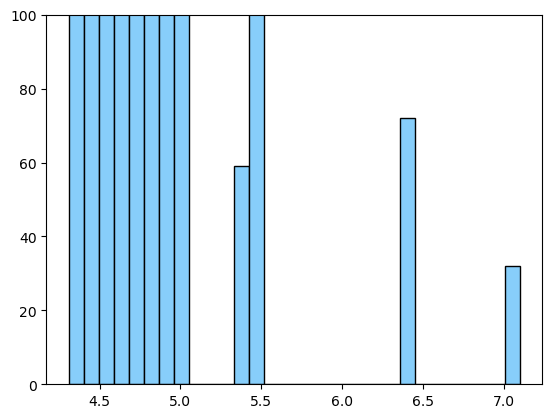

In [39]:
print(new_meta_array[rows_with_eqs, 6])

mags_hist = []
for maghist in new_meta_array[rows_with_eqs, 6]:
    maghist = float(maghist)
    mags_hist.append(maghist)

plt.hist(mags_hist, bins = 30, color = 'lightskyblue', edgecolor = 'black')
plt.ylim(0,100);

In [40]:
np.save(realdata_dir + 'real_metadata_w_gauss_pos.npy', new_meta_array)

# Columns:
# 0: station name
# 1: date sample came from
# 2: sample start time
# 3: sample end time
# 4: random n counter
# 5: sample P-wave arrives at (gauss pos)
# 6: earthquake magnitude

np.save(realdata_dir + 'real_metadata_rows_w_eqs.npy', np.array(rows_with_eqs))
np.save(realdata_dir + 'real_metadata_p_arrivals_per_sample.npy', np.array(p_count_info))